## Introduction Plot 

The aim of this plot is to show: 
- the region being sampled, topography etc
- glider tracks 
- Sampling rates in the vertical and horizontal 

In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [26]:
ds_659

<xarray.Dataset>
Dimensions:      (ctd_data_point: 1363330)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 nan nan nan nan ... 1.165 1.037 nan
    latitude     (ctd_data_point) float64 -51.51 -51.51 -51.51 ... -51.7 -51.7
    longitude    (ctd_data_point) float64 30.03 30.03 30.03 ... 38.99 38.99
    temperature  (ctd_data_point) float64 3.564 3.561 3.56 ... 1.812 1.811 1.814
    salinity     (ctd_data_point) float64 nan nan nan nan ... 33.89 33.89 nan
    dives        (ctd_data_point) float64 1.0 1.0 1.0 1.0 ... 462.5 462.5 462.5
    time         (ctd_data_point) datetime64[ns] 2019-04-30T13:20:51.23000345...

In [81]:
days = ds_659.time - np.datetime64('2019-01-01')
days_round_659 = (days / np.timedelta64(1, 'D')).round()
ds_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_660.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660['days'] = (days / np.timedelta64(1, 'D'))

In [5]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

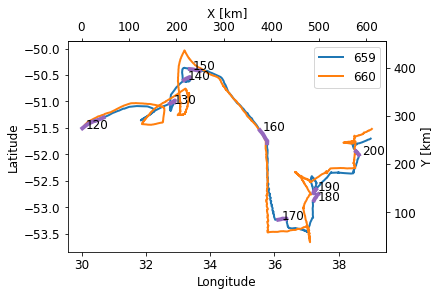

In [87]:
# Glider tracks 


fig, ax = plt.subplots(figsize = (6,4), 
                       constrained_layout=True)

#plt.subplot(211)
ax.plot(ds_659.longitude, ds_659.latitude, 
         label='659', color='tab:blue', linewidth=2)
ax.plot(ds_660.longitude, ds_660.latitude, 
         label='660', color='tab:orange', linewidth=2)

ax.legend()
days = np.linspace(120,200,9)
for i in days: 
    ax.plot(ds_659.longitude.where(days_round_659==i, drop=True), 
             ds_659.latitude.where(days_round_659==i, drop=True), 
             linewidth=4, color='tab:purple')
    ax.text(ds_659.longitude.where(days_round_659==i, drop=True)[0]+0.1, 
             ds_659.latitude.where(days_round_659==i, drop=True)[0], 
             int(i))
    

#plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Glider Tracks')

def forward_2nd_xaxis(x):
    return (x-30)*110*np.cos(np.pi/180*-52)
    #great_circle_distance(30, -54, x, -52)
    
def inverse_2nd_xaxis(x):
    return (x)/110/np.cos(np.pi/180*-52) + 30

def forward_2nd_yaxis(x):
    return (x+54)*110
    #great_circle_distance(30, -54, x, -52)
    
def inverse_2nd_yaxis(x):
    return (x)/110 - 54


secxax = ax.secondary_xaxis('top', 
            functions=(forward_2nd_xaxis, inverse_2nd_xaxis))
secxax.set_xlabel('X [km]')

secyax = ax.secondary_yaxis('right', 
            functions=(forward_2nd_yaxis, inverse_2nd_yaxis))
secyax.set_ylabel('Y [km]')

#plt.subplot(212)
#plt.plot(X_659, Y_659, label='659')
#plt.plot(X_660, Y_660, label='660')
#plt.grid()
#plt.xlabel('X (km)')
#plt.ylabel('Y (km)')
plt.savefig('glider_tracks.pdf')

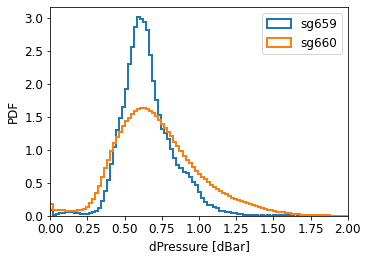

In [88]:
# Vertical sampling 
fig, ax = plt.subplots(figsize = (5,3.5), 
                       constrained_layout=True)

np.abs(ds_659.pressure.diff('ctd_data_point')).plot.hist(ax=ax, bins=np.linspace(0,2,100), 
                                                         histtype='step', color='tab:blue',
                                                        density=True, label='sg659',
                                                        linewidth=2);
np.abs(ds_660.pressure.diff('ctd_data_point')).plot.hist(ax= ax, bins=np.linspace(0,2,100), 
                                                         histtype='step', color='tab:orange',
                                                        density=True, label='sg660',
                                                        linewidth=2);

plt.legend()

ax.set_xlim([0, 2])
ax.set_ylabel('PDF')
ax.set_xlabel('dPressure [dBar]')
ax.set_title('')
plt.savefig('dZ.pdf')

In [52]:
# Horizontal Sampling 


In [63]:
dist_659 = gt.utils.distance(ds_659.longitude, 
                       ds_659.latitude)

ds_659['distance'] = xr.DataArray(np.cumsum(dist_659), 
                           dims= ['ctd_data_point'])

dist_660 = gt.utils.distance(ds_660.longitude, 
                       ds_660.latitude)

ds_660['distance'] = xr.DataArray(np.cumsum(dist_660), 
                           dims= ['ctd_data_point'])

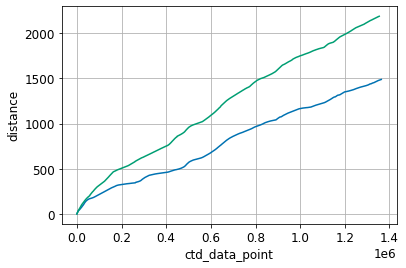

In [104]:
(ds_659['distance']/1e3).plot()
(ds_660['distance']/1e3).plot()
plt.grid()

In [107]:
print((ds_659['distance']/1e3)[-1])
print((ds_660['distance']/1e3)[-1])

<xarray.DataArray 'distance' ()>
array(1488.76109881)
<xarray.DataArray 'distance' ()>
array(2188.78208689)


In [64]:
dist_659_surf = ds_659.distance.where(ds_659.pressure<50).groupby(ds_659.dives).mean()
dist_659_mid = ds_659.distance.where(ds_659.pressure<525).where(ds_659.pressure>475).groupby(ds_659.dives).mean()
dist_659_bottom = ds_659.distance.where(ds_659.pressure>950).groupby(ds_659.dives).mean()

dist_660_surf = ds_660.distance.where(ds_660.pressure<50).groupby(ds_660.dives).mean()
dist_660_mid = ds_660.distance.where(ds_660.pressure<525).where(ds_660.pressure>475).groupby(ds_660.dives).mean()
dist_660_bottom = ds_660.distance.where(ds_660.pressure>950).groupby(ds_660.dives).mean()

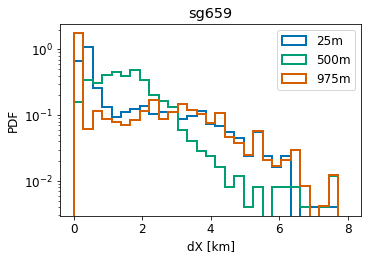

In [89]:
fig, ax = plt.subplots(figsize = (5,3.5), 
                       constrained_layout=True)

(dist_659_surf/1e3).diff('dives').plot.hist(bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                           label='25m');

(dist_659_mid/1e3).diff('dives').plot.hist(bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                          label='500m');

(dist_659_bottom/1e3).diff('dives').plot.hist(bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2,
                                             label='975m');

ax.set_xlabel('dX [km]')
ax.set_ylabel('PDF')
ax.set_yscale('log')
ax.set_title('sg659')
plt.legend()

plt.savefig('dX.pdf')

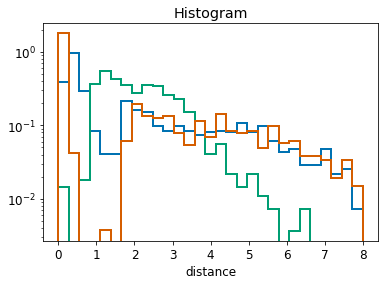

In [73]:
(dist_660_surf/1e3).diff('dives').plot.hist(bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2);

(dist_660_mid/1e3).diff('dives').plot.hist(bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2);

(dist_660_bottom/1e3).diff('dives').plot.hist(bins = np.linspace(0,8,30), 
                                      density=True, histtype='step', linewidth=2);

plt.yscale('log')

### Caution - to be meaningful the plots below should be considered in variance preserving form.

Text(0.5, 1.0, 'sg659')

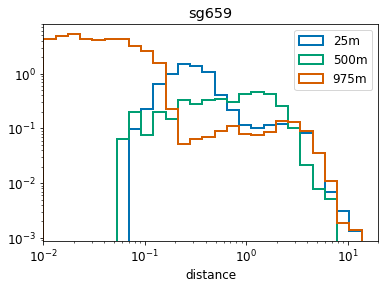

In [101]:

(dist_659_surf/1e3).diff('dives').plot.hist(bins = np.logspace(-2,1.5,30), label='25m',
                                 density=True, histtype='step', linewidth=2);
(dist_659_mid/1e3).diff('dives').plot.hist(bins = np.logspace(-2,1.5,30), label='500m',
                                      density=True, histtype='step', linewidth=2);
(dist_659_bottom/1e3).diff('dives').plot.hist(bins = np.logspace(-2,1.5,30), label='975m',
                                      density=True, histtype='step', linewidth=2);


plt.xlim([1e-2, 20])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('sg659')

Text(0.5, 1.0, 'sg660')

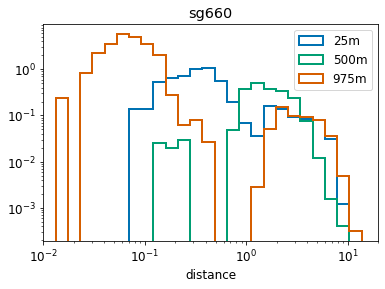

In [100]:
(dist_660_surf/1e3).diff('dives').plot.hist(bins = np.logspace(-2,1.5,30), label='25m',
                                      density=True, histtype='step', linewidth=2);
(dist_660_mid/1e3).diff('dives').plot.hist(bins = np.logspace(-2,1.5,30), label='500m',
                                      density=True, histtype='step', linewidth=2);
(dist_660_bottom/1e3).diff('dives').plot.hist(bins = np.logspace(-2,1.5,30), label='975m',
                                      density=True, histtype='step', linewidth=2);


plt.xlim([1e-2, 20])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('sg660')

In [83]:
# Time sampling 

days_659_surf = ds_659.days.where(ds_659.pressure<50).groupby(ds_659.dives).mean()
days_659_mid = ds_659.days.where(ds_659.pressure<525).where(ds_659.pressure>475).groupby(ds_659.dives).mean()
days_659_bottom = ds_659.days.where(ds_659.pressure>950).groupby(ds_659.dives).mean()

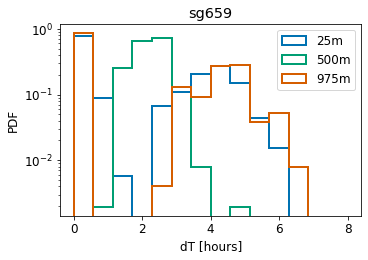

In [91]:
fig, ax = plt.subplots(figsize = (5,3.5), 
                       constrained_layout=True)

(days_659_surf*24).diff('dives').plot.hist(bins = np.linspace(0,8,15), 
                                      density=True, histtype='step', linewidth=2,
                                           label='25m');

(days_659_mid*24).diff('dives').plot.hist(bins = np.linspace(0,8,15), 
                                      density=True, histtype='step', linewidth=2,
                                          label='500m');

(days_659_bottom*24).diff('dives').plot.hist(bins = np.linspace(0,8,15), 
                                      density=True, histtype='step', linewidth=2,
                                             label='975m');

ax.set_xlabel('dT [hours]')
ax.set_ylabel('PDF')
ax.set_yscale('log')
ax.set_title('sg659')
plt.legend()

plt.savefig('dT.pdf')